In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%matplotlib inline

In [21]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import charts

In [6]:
cleaned_obs = pd.read_csv("clean.csv")

In [7]:
obs = charts.setup_individual_obs_df(cleaned_obs)

In [8]:
bmi_percentiles = pd.read_csv("bmiagerev.csv")
bmi_percentiles = charts.setup_percentiles(bmi_percentiles)
wt_percentiles = pd.read_csv("wtage.csv")
wt_percentiles = charts.setup_percentiles(wt_percentiles)
ht_percentiles = pd.read_csv("statage.csv")
ht_percentiles = charts.setup_percentiles(ht_percentiles)

In [22]:
interactive(charts.overlap_view, obs_df=fixed(obs), 
            subjid=[47085108, 46663895, 46793195, 47058401, 46717134], param=['HEIGHTCM', 'WEIGHTKG'], 
            include_carry_forward=[True, False], include_percentiles=[True, False],
            wt_df=fixed(wt_percentiles), ht_df=fixed(ht_percentiles))

interactive(children=(Dropdown(description='subjid', options=(47085108, 46663895, 46793195, 47058401, 46717134…

In [10]:
uniq_ids = cleaned_obs['subjid'].unique()

In [11]:
sample = np.random.choice(uniq_ids, size=16)

In [12]:
sample

array([46926381, 47036809, 46823952, 46953894, 47100937, 46951908,
       46857783, 47082722, 46879609, 46873905, 46795909, 46849967,
       46781430, 46957254, 46864636, 46859308])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

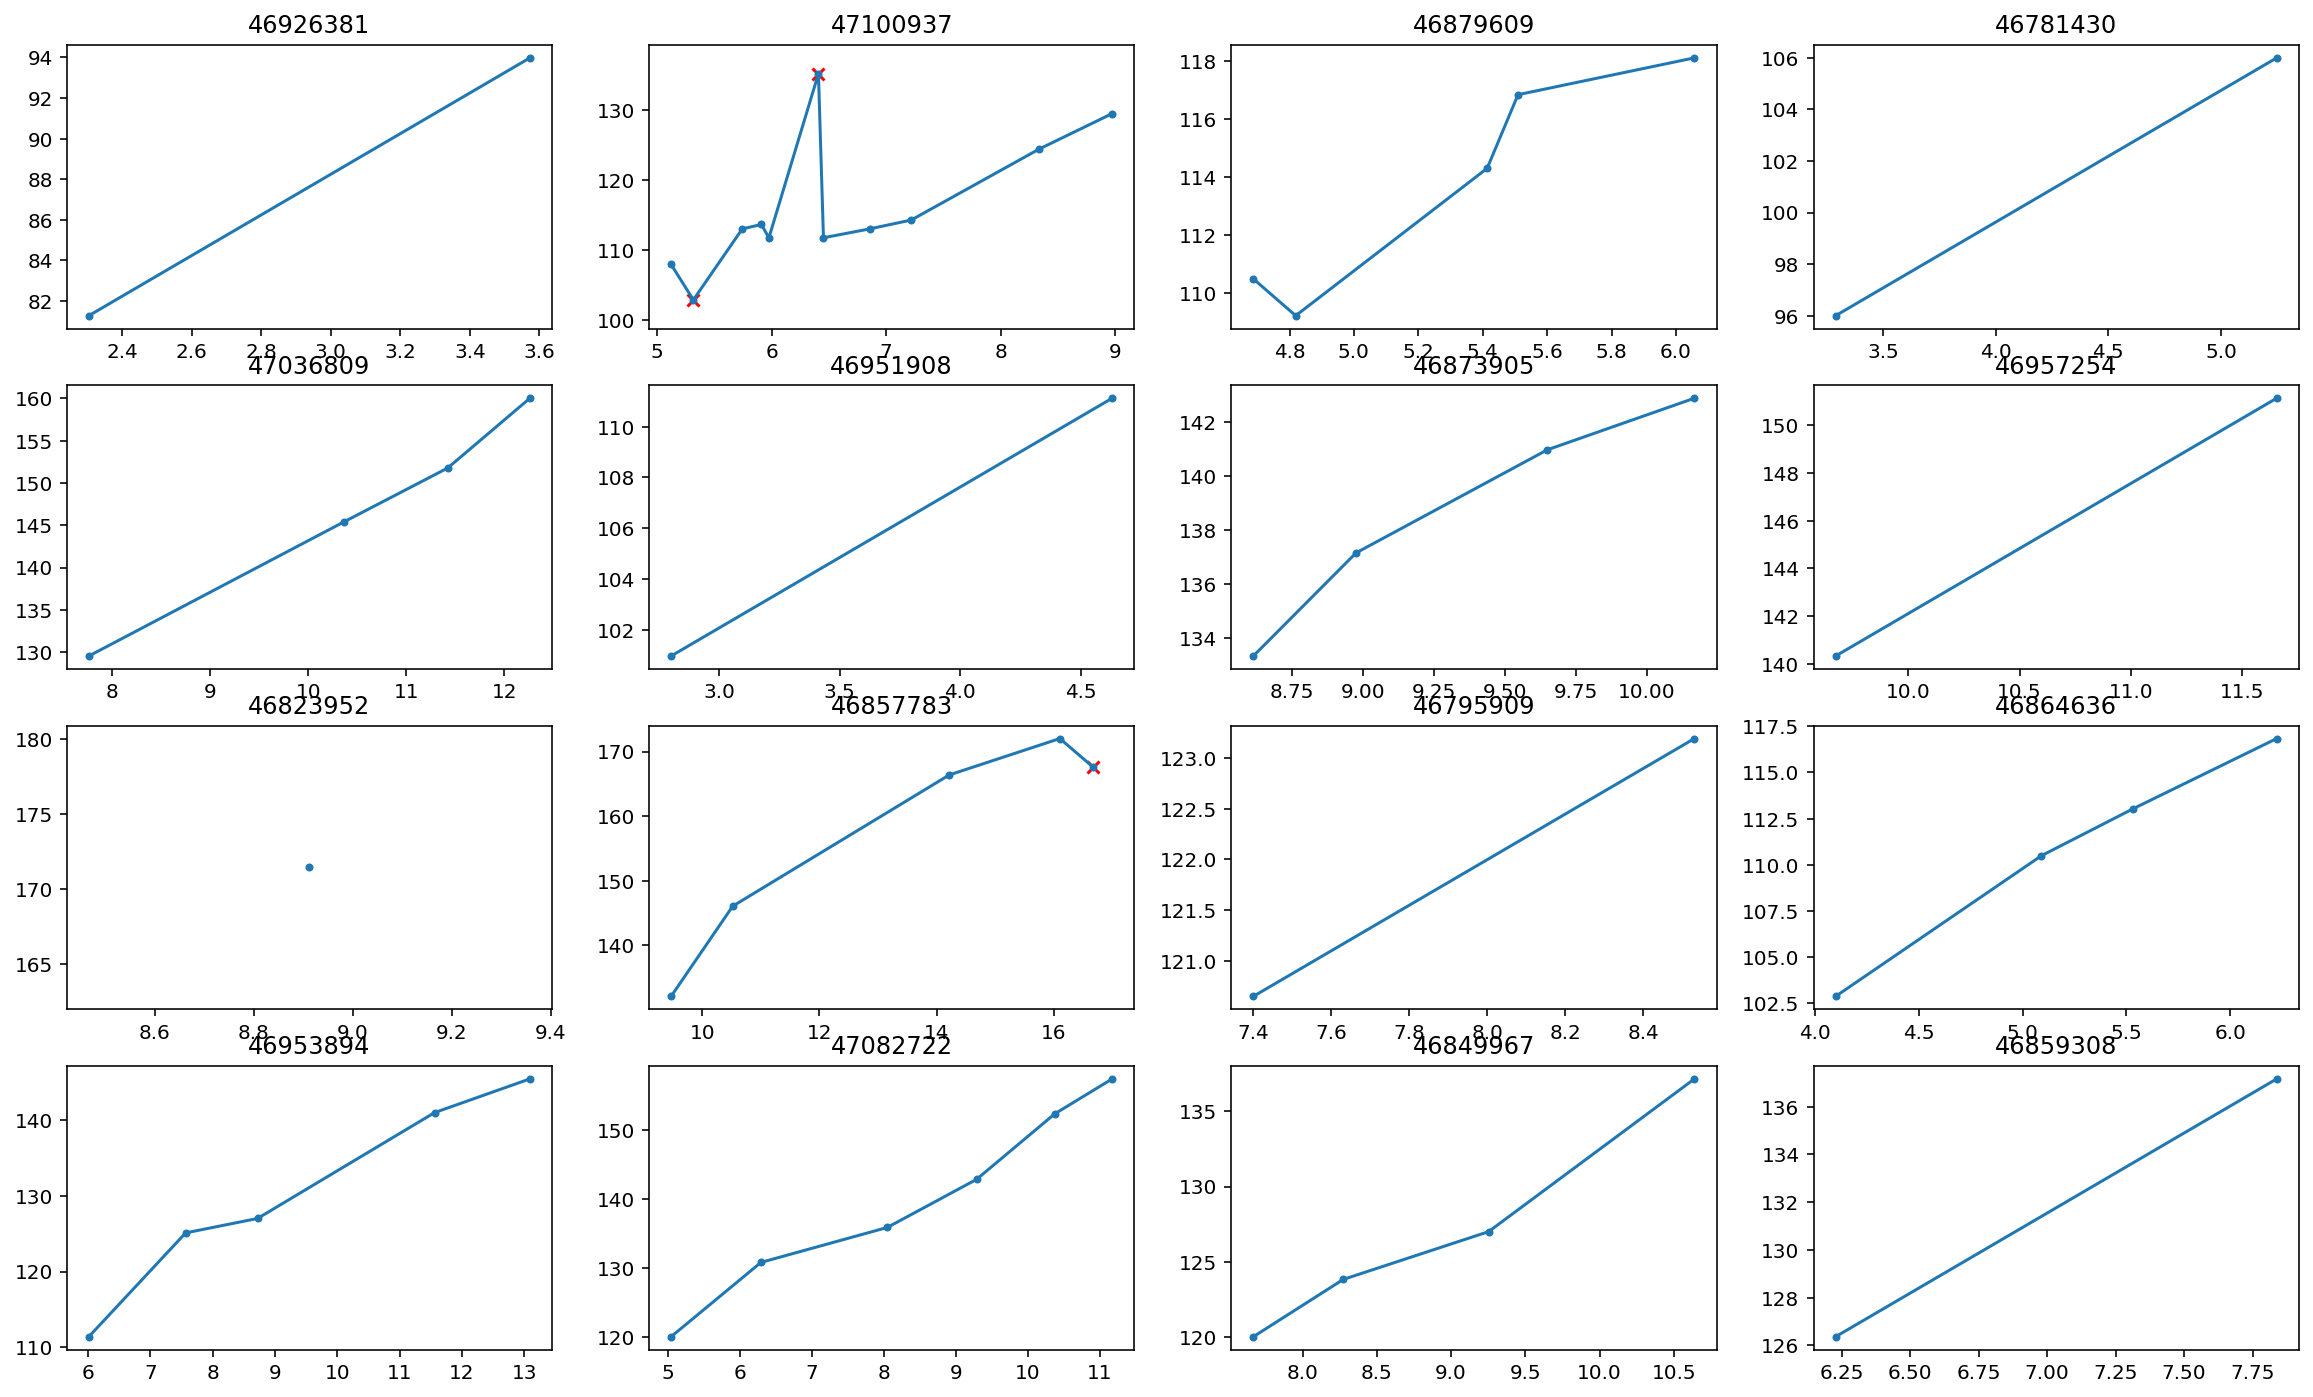

In [23]:
charts.four_by_four_view(cleaned_obs, sample, 'HEIGHTCM')

In [14]:
merged_df = charts.setup_merged_df(cleaned_obs)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

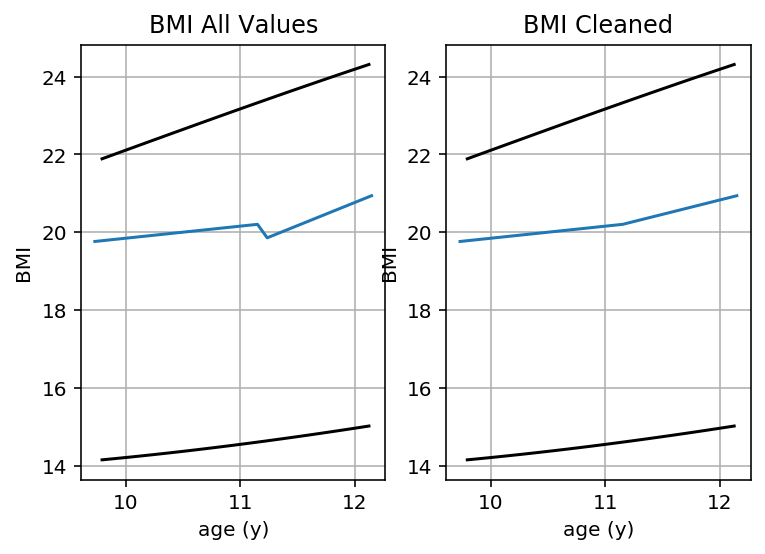

In [24]:
charts.bmi_with_percentiles(merged_df, bmi_percentiles, 46717134)

In [65]:
pd.set_option('precision', 3)
min_toggle = widgets.ToggleButton(value=True, description='Minimum BMI')
mean_toggle = widgets.ToggleButton(value=True, description='Mean BMI')
max_toggle = widgets.ToggleButton(value=True, description='Maximum BMI')
std_toggle = widgets.ToggleButton(value=True, description='BMI Standard Deviation')
med_toggle = widgets.ToggleButton(value=True, description='Median BMI')
count_toggle = widgets.ToggleButton(value=True, description='Count')
diff_toggle = widgets.ToggleButton(value=True, description='Mean BMI Difference')
ui = widgets.HBox([min_toggle, mean_toggle, max_toggle, std_toggle, med_toggle, count_toggle, diff_toggle])
out = widgets.Output()
widgets.interactive_output(charts.bmi_stats, {'merged_df': fixed(merged_df), 'include_min': min_toggle, 
         'include_mean': mean_toggle, 'include_max': max_toggle, 'include_std': std_toggle, 
         'include_median': med_toggle, 'include_mean_diff': diff_toggle, 'include_count': count_toggle,
         'out': fixed(out)})
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '                 min_clean  mean_clean…